In [ ]:
#Go to our google drive
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)
#Specify the location of our storage
path = r"/content/drive/My Drive/CSS/"

Mounted at /content/drive/


**Web Scraping**

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
from fake_useragent import UserAgent

def get_info(add_url):
    result = {}
    home = 'https://kolesa.kz'
    url = home + add_url
    ua = UserAgent()
    headers = {'User-Agent': ua.chrome}
    response = requests.get(url,headers=headers)
    response.encoding ='utf8'
    page = BeautifulSoup(response.text, 'html.parser')
    try:
        result['Brand'] = str(page.find('h1', class_='offer__title').find('span').text)
        result['Model'] = str(page.find('h1', class_='offer__title').find_all('span')[1].text)      
        result['Year'] = str(page.find('h1', class_='offer__title').find_all('span')[2].text)
        result['Price'] = str(page.find('div', class_='offer__price').text.replace(u'\xa0', u''))
    except:
        pass
    titles, values = page.find_all('dt'), page.find_all('dd')
    for i in range(len(titles)):
        try:
            result[titles[i].find('span').text.strip()] = values[i].text.strip()
        except:
            pass
    return result

def car_links(i):
    data = []
    page = f'Web page scrapping #{i}'
    print(page)
    ua = UserAgent()
    headers = {'User-Agent': ua.chrome}
    url = 'https://kolesa.kz/cars/?page='+str(i)
    response = requests.get(url, headers=headers).text
    soup = BeautifulSoup(response, 'lxml')
    all_links = soup.find_all('span', class_='a-el-info-title')
    for link in all_links:
        link = link.find('a').get('href')
        data.append(get_info(link))
    df = pd.DataFrame(data)
   #df.to_csv(f'page{i}.csv')

Web page scrapping #999
--- 13 seconds ---


In [ ]:
import time
start_time = time.time()
for i in range(999,1000):
    car_links(i)
print("--- %s seconds ---" % (round(time.time() - start_time)))

Web page scrapping #999
--- 16 seconds ---


**Data Preparation** **and** **Normalize Data**

In [ ]:
import pandas as pd
import glob 

df = pd.DataFrame()
files = glob.glob(path + "*.csv")
for file in files:
    df1 = pd.read_csv(file)
    df = pd.concat([df,df1]) 
df.to_csv(path + 'Kolesakz.csv',index = None)

df.info()

In [ ]:
import pandas as pd
df = pd.read_csv(path + 'Kolesakz.csv')
df2 = df

In [ ]:
df = df.drop(['Unnamed: 0','VIN','Аварийная/Не на ходу','Двигатель'], axis = 1)
df

,Brand,Model,Year,Price,Город,Кузов,"Объем двигателя, л",Пробег,Коробка передач,Руль,Цвет,Привод,Растаможен в Казахстане
0,ВАЗ (Lada),2114 (хэтчбек),2013,2350000\n ₸\n,Алматы,хэтчбек,1.6 (бензин),149 165 км,механика,слева,белый,передний привод,Да
1,ВАЗ (Lada),2190 (седан),2016,2200000\n ₸\n,Караганда,седан,1.6 (бензин),103 253 км,автомат,слева,серебристый,передний привод,Нет
2,Kia,Sportage,2015,7600000\n ₸\n,Нур-Султан (Астана),кроссовер,2 (бензин),118 000 км,автомат,слева,белый,полный привод,Да
3,ВАЗ (Lada),2191 (лифтбек),2016,2300000\n ₸\n,Нур-Султан (Астана),лифтбек,1.6 (бензин),130 000 км,автомат,слева,серебристый,передний привод,Нет
4,Skoda,Octavia,2012,3800000\n ₸\n,Нур-Султан (Астана),лифтбек,1.6 (бензин),253 000 км,автомат,слева,белый,передний привод,Да
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19895,ГАЗ,31029 (Волга),1995,3000000\n ₸\n,Тараз,седан,2.4 (бензин),27 000 км,механика,слева,белый,задний привод,Да
19896,BMW,318,1993,1000000\n ₸\n,Актобе,седан,1.8 (бензин),325 000 км,механика,слева,серебристый,задний привод,Да
19897,Nissan,Primera,1998,750000\n ₸\n,Атырау,седан,2 (бензин),455 000 км,механика,слева,серый,NaN,Да
19898,Mitsubishi,Space Runner,1996,2150000\n ₸\n,Усть-Каменогорск,минивэн,1.8 (бензин),206 000 км,механика,слева,жёлтый,передний привод,Да


In [ ]:
df.rename(columns={"Город": "City", "Кузов": "Body_type","Объем двигателя, л": "Volume", "Пробег":"Milage","Коробка передач":"Transmission","Руль":"Wheel","Цвет":"Color","Привод":"Drive","Растаможен в Казахстане":"KZ_or_Not"}, inplace = True)

In [ ]:
milage_mean =  df.Milage.dropna().apply(lambda x: int(x.replace(' ','')[:-2])).mean()

In [ ]:
mm = str(round(milage_mean)) + ' км'

In [ ]:
df.Milage = df.Milage.fillna(mm).apply(lambda x: int(x.replace(' ','')[:-2]))

In [ ]:
df.dropna(inplace=True)
df.Price = df.Price.apply(lambda x: int(x[:-7]))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17051 entries, 0 to 19899
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Brand         17051 non-null  object
 1   Model         17051 non-null  object
 2   Year          17051 non-null  object
 3   Price         17051 non-null  int64 
 4   City          17051 non-null  object
 5   Body_type     17051 non-null  object
 6   Volume        17051 non-null  object
 7   Milage        17051 non-null  int64 
 8   Transmission  17051 non-null  object
 9   Wheel         17051 non-null  object
 10  Color         17051 non-null  object
 11  Drive         17051 non-null  object
 12  KZ_or_Not     17051 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.8+ MB


In [ ]:
import re
def clean(x):
    try:
        x = int(x)
        return x
    except:
        if x.isdigit():
            return int(x)
        else:
            return 2005

In [ ]:
df.Year = df.Year.apply(clean)

In [ ]:
df["fuel_type"] = df.Volume.apply(lambda x: x.split(' ')[1])
df["Volume"] = df.Volume.apply(lambda x: float(x.split(' ')[0]))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17051 entries, 0 to 19899
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         17051 non-null  object 
 1   Model         17051 non-null  object 
 2   Year          17051 non-null  int64  
 3   Price         17051 non-null  int64  
 4   City          17051 non-null  object 
 5   Body_type     17051 non-null  object 
 6   Volume        17051 non-null  float64
 7   Milage        17051 non-null  int64  
 8   Transmission  17051 non-null  object 
 9   Wheel         17051 non-null  object 
 10  Color         17051 non-null  object 
 11  Drive         17051 non-null  object 
 12  KZ_or_Not     17051 non-null  object 
 13  fuel_type     17051 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 2.0+ MB


In [ ]:
df

,Brand,Model,Year,Price,City,Body_type,Volume,Milage,Transmission,Wheel,Color,Drive,KZ_or_Not,fuel_type
0,ВАЗ (Lada),2114 (хэтчбек),2013,2350000,Алматы,хэтчбек,1.6,149165,механика,слева,белый,передний привод,Да,(бензин)
1,ВАЗ (Lada),2190 (седан),2016,2200000,Караганда,седан,1.6,103253,автомат,слева,серебристый,передний привод,Нет,(бензин)
2,Kia,Sportage,2015,7600000,Нур-Султан (Астана),кроссовер,2.0,118000,автомат,слева,белый,полный привод,Да,(бензин)
3,ВАЗ (Lada),2191 (лифтбек),2016,2300000,Нур-Султан (Астана),лифтбек,1.6,130000,автомат,слева,серебристый,передний привод,Нет,(бензин)
4,Skoda,Octavia,2012,3800000,Нур-Султан (Астана),лифтбек,1.6,253000,автомат,слева,белый,передний привод,Да,(бензин)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19894,ГАЗ,2410 (Волга),1990,4500000,Тараз,седан,2.4,10000,механика,слева,бежевый,задний привод,Да,(бензин)
19895,ГАЗ,31029 (Волга),1995,3000000,Тараз,седан,2.4,27000,механика,слева,белый,задний привод,Да,(бензин)
19896,BMW,318,1993,1000000,Актобе,седан,1.8,325000,механика,слева,серебристый,задний привод,Да,(бензин)
19898,Mitsubishi,Space Runner,1996,2150000,Усть-Каменогорск,минивэн,1.8,206000,механика,слева,жёлтый,передний привод,Да,(бензин)


**Drawing charts and Analyzing data**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

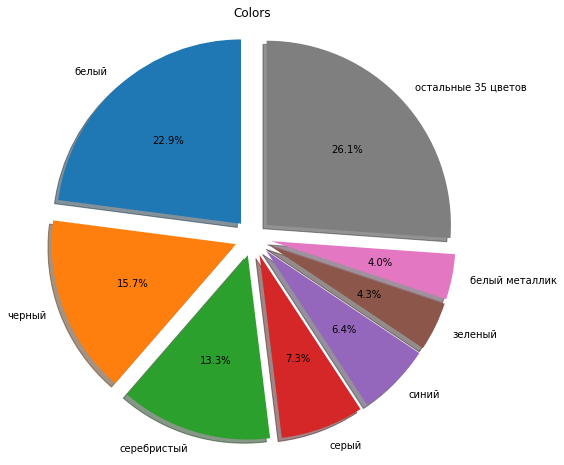

In [ ]:
counts = df.Color.value_counts()
top7 = counts.head(7)
if len(counts) > 7:
    top7['остальные {0} цветов'.format(len(counts) - 7)] = sum(counts[7:])
# temp2.plot(kind='pie',figsize=(20, 10))

c_index = top7.index
c_value = top7.values
explode = [0.1]*len(c_value)
fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.title.set_text('Colors')
ax2.pie(c_value, explode= explode, labels=c_index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show();

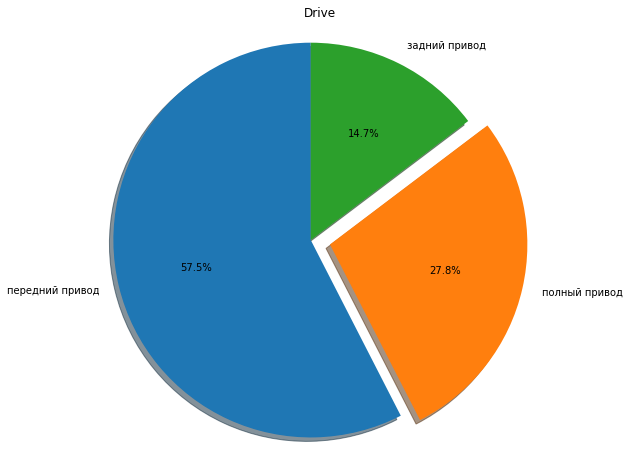

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
d_index = df.Drive.value_counts().index
d_value = df.Drive.value_counts().values
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.title.set_text('Drive')
ax1.pie(d_value, explode=explode, labels=d_index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.

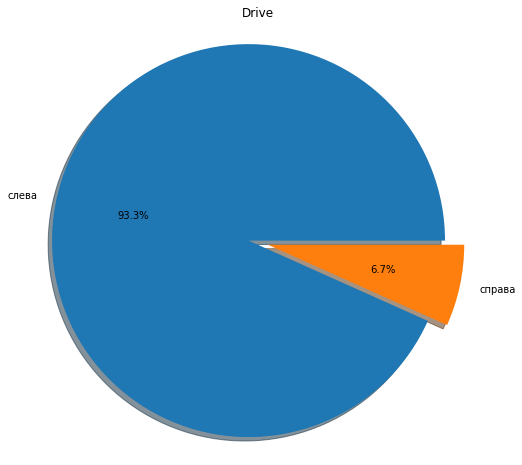

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
d_index = df.Wheel.value_counts().index
d_value = df.Wheel.value_counts().values
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.title.set_text('Drive')
ax1.pie(d_value, explode=explode, labels=d_index, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.

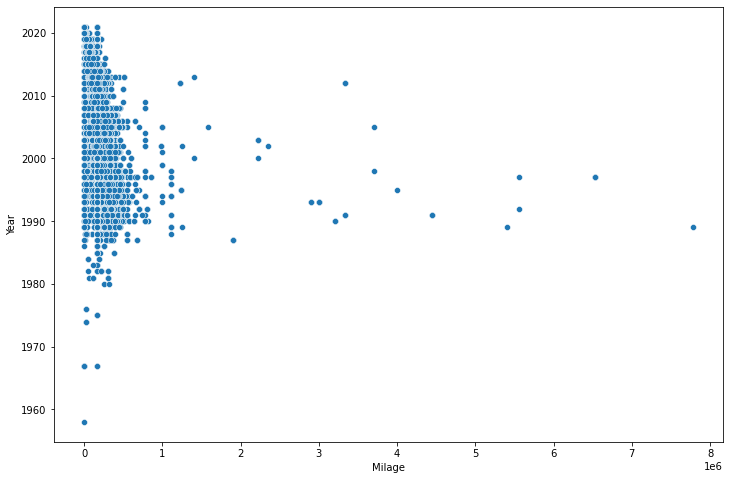

In [ ]:
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 8)
sns.scatterplot(data=df, x="Milage", y="Year");

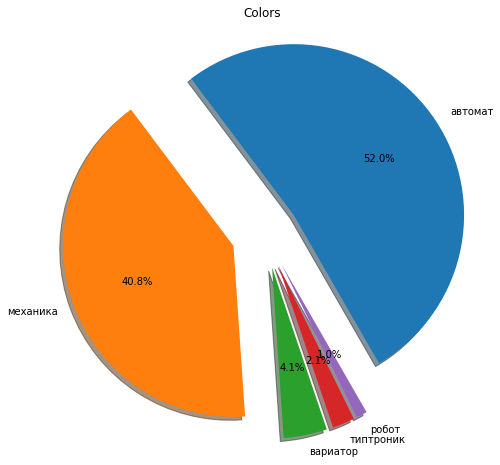

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

c_index = df.Transmission.value_counts().index
c_value = df.Transmission.value_counts().values
explode = [0.2]*len(c_value)
fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.title.set_text('Colors')
ax2.pie(c_value, explode = explode,labels=c_index, autopct='%1.1f%%',
        shadow=True, startangle=300)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show();

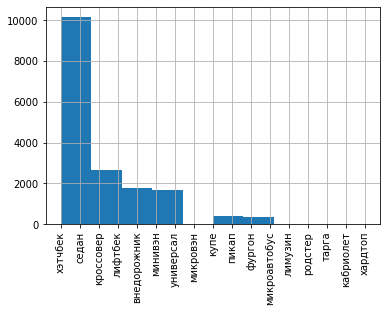

In [ ]:
df.Body_type.hist(xrot=90);

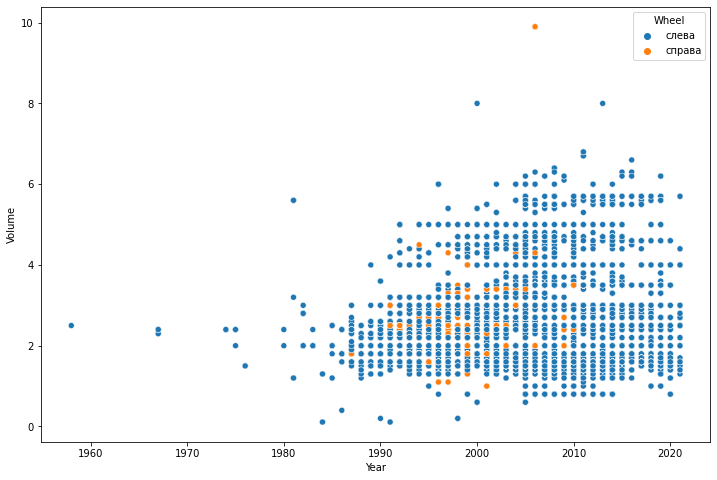

In [ ]:
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 8)
sns.scatterplot(data=df, x="Year", y="Volume", hue="Wheel");